# Programming Assignment 2

Here is the code snippet for the dqn algorithm.
```python
def dqn(agent, env, n_episodes=100, max_t=500):
    scores_over_episodes = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            # Act
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)

            # Learn
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break

        scores_over_episodes.append(score)

        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score))

    return scores_over_episodes
```

### Imports

In [12]:
import gym
from duelingDQN import dqn, DuelingDQNAgent
import matplotlib.pyplot as plt
from vars import *
import numpy as np
from mcReinforce import mc_reinforce, REINFORCEAgent

ENVS = [HyperEnv('CartPole-v1', 150, 1000, 64, 1e-4, 100, 0.99, 0.5, 128, 64), HyperEnv('Acrobot-v1', 100, 300, 128, 1e-3, 500, 0.99, 0.1, 32, 64)]

In [3]:
def draw_experiment_dqn(hyper_env: HyperEnv):
    print(f"\nTraining and evaluating Dueling DQN agent on {hyper_env.name} environment:")
    env = gym.make(hyper_env.name)
    
    rewards1 = []
    rewards2 = []
    for i_exp in range(5):
        print("\nexperiment {} :".format(i_exp+1))
        dueling_dqn_agent_type1 = DuelingDQNAgent(env.observation_space.shape[0], env.action_space.n, "mean", hyper_env)
        dueling_dqn_agent_type2 = DuelingDQNAgent(env.observation_space.shape[0], env.action_space.n, "max", hyper_env)
        scores1 = dqn(dueling_dqn_agent_type1, env, n_episodes=hyper_env.n_episodes, max_t=hyper_env.max_t)
        scores2 = dqn(dueling_dqn_agent_type2, env, n_episodes=hyper_env.n_episodes, max_t=hyper_env.max_t)
        rewards1.append(scores1)
        rewards2.append(scores2)
    avg_reward1 = np.array(rewards1).mean(0)
    std_reward1 = np.array(rewards1).std(0)
    avg_reward2 = np.array(rewards2).mean(0)
    std_reward2 = np.array(rewards2).std(0)
    
    x_axis = np.arange(len(rewards1[0]))
    plt.fill_between(x_axis, avg_reward1 - std_reward1, avg_reward1 + std_reward1, alpha=0.5, label="type 1: mean")
    plt.plot(avg_reward1)
    x_axis = np.arange(len(rewards2[0]))
    plt.fill_between(x_axis, avg_reward2 - std_reward2, avg_reward2 + std_reward2, alpha=0.5, label="type 2: max")
    plt.plot(avg_reward2)
    plt.title("Reward vs Episode")
    plt.legend()
    plt.show()

## DDQN Cartpole


Training and evaluating Dueling DQN agent on CartPole-v1 environment:

experiment 1 :
Episode 100	Score: 209.00
Episode 100	Score: 191.00
Episode 150	Score: 555.000
experiment 2 :
Episode 100	Score: 167.00
Episode 100	Score: 141.000
Episode 150	Score: 227.00
experiment 3 :
Episode 100	Score: 144.00
Episode 100	Score: 199.00
Episode 150	Score: 1000.00
experiment 4 :
Episode 100	Score: 124.00
Episode 100	Score: 399.00
Episode 150	Score: 1000.00
experiment 5 :
Episode 100	Score: 133.00
Episode 100	Score: 175.000
Episode 150	Score: 1000.00

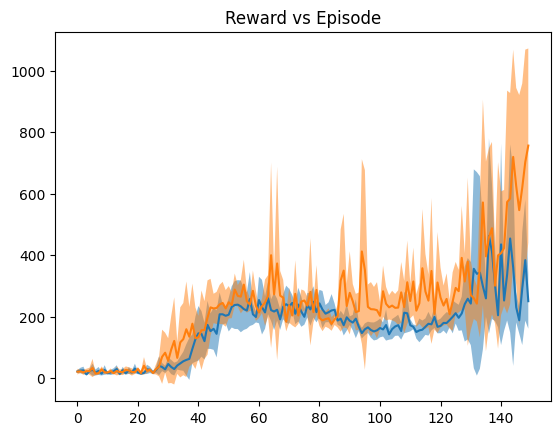

In [12]:
cartpole_parameters = ENVS[0]
draw_experiment_dqn(cartpole_parameters)


## DDQN Acrobot


Training and evaluating Dueling DQN agent on Acrobot-v1 environment:

experiment 1 :
Episode 100	Score: -234.00
Episode 100	Score: -94.00

experiment 2 :
Episode 100	Score: -121.00
Episode 100	Score: -164.00

experiment 3 :
Episode 100	Score: -300.00
Episode 100	Score: -139.00

experiment 4 :
Episode 100	Score: -113.00
Episode 100	Score: -140.00

experiment 5 :
Episode 100	Score: -100.00
Episode 100	Score: -133.00


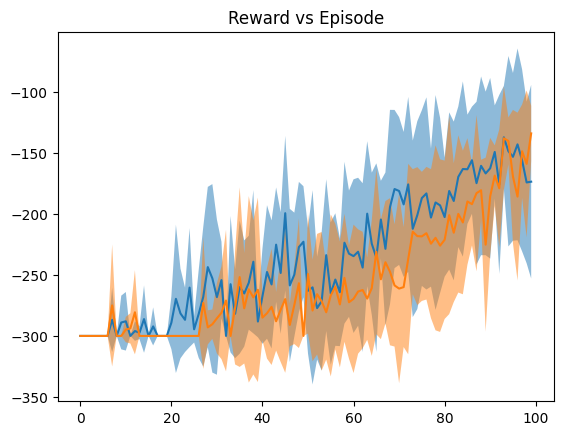

In [31]:
acrobot_parameters = ENVS[1]
draw_experiment_dqn(acrobot_parameters)

## DDQN Inferences

The run is very long so it had to be cut into a pretty small number of episodes.
The cartpole environment is much easier to handle for the algorithm than the acrobot due to the fact that the only way of having a better reward is by crossing the height limit by exploring. The variance is high across the experiments.
Some kind of forgetting was sometimes happening in the experiments where the reward went down for chunks of episodes.
In cartpole, the type2 is performing better than 1 but on acrobot, it is the contrary (In both cases, the two types are pretty close). Having type 1, the values of actions are lower and thus probably leading to more exploration. That's why it is performing better in acrobot and worse in cartpole as this last one doesn't require as much exploration.

In [13]:
def draw_experiment_reinforce(hyper_env: HyperEnv):
    print(f"\nTraining and evaluating Monte Carlo REINFORCE agent on {hyper_env.name} environment:")
    env = gym.make(hyper_env.name)
    
    rewards1 = []
    rewards2 = []
    for i_exp in range(5):
        print("\nexperiment {} :".format(i_exp+1))
        monte_carlo_reinforce_agent1 = REINFORCEAgent(env.observation_space.shape[0], env.action_space.n, hyper_env.layer_size1, hyper_env.lr, hyper_env.gamma)
        monte_carlo_reinforce_agent2 = REINFORCEAgent(env.observation_space.shape[0], env.action_space.n, hyper_env.layer_size1, hyper_env.lr, hyper_env.gamma, baseline=True)
        scores1 = mc_reinforce(monte_carlo_reinforce_agent1, env, hyper_env.n_episodes, hyper_env.max_t)
        scores2 = mc_reinforce(monte_carlo_reinforce_agent2, env, hyper_env.n_episodes, hyper_env.max_t)
        rewards1.append(scores1)
        rewards2.append(scores2)
    avg_reward1 = np.array(rewards1).mean(0)
    std_reward1 = np.array(rewards1).std(0)
    avg_reward2 = np.array(rewards2).mean(0)
    std_reward2 = np.array(rewards2).std(0)
    
    x_axis = np.arange(len(rewards1[0]))
    plt.fill_between(x_axis, avg_reward1 - std_reward1, avg_reward1 + std_reward1, alpha=0.5, label="type 1: mean")
    plt.plot(avg_reward1)
    x_axis = np.arange(len(rewards2[0]))
    plt.fill_between(x_axis, avg_reward2 - std_reward2, avg_reward2 + std_reward2, alpha=0.5, label="type 2: max")
    plt.plot(avg_reward2)
    plt.title("Reward vs Episode")
    plt.legend()
    plt.show()

## REINFORCE cartpole

In [ ]:
cartpole_mc = HyperEnv('CartPole-v1', 500, 1000, 64, 1e-2, 100, 0.99, 1, 128, 64)
draw_experiment_reinforce(cartpole_mc)


Training and evaluating Monte Carlo REINFORCE agent on CartPole-v1 environment:

experiment 1 :
Episode 0, Average Score: 19.0
Episode 100, Average Score: 101.01
Episode 200, Average Score: 157.74
Episode 300, Average Score: 150.27
Episode 400, Average Score: 111.26
Episode 0, Average Score: 35.0
Episode 100, Average Score: 69.62
Episode 200, Average Score: 112.21



Training and evaluating Monte Carlo REINFORCE agent on Acrobot-v1 environment:

experiment 1 :
Episode 0, Average Score: -300.0
Episode 0, Average Score: -300.0

experiment 2 :
Episode 0, Average Score: -300.0
Episode 0, Average Score: -300.0

experiment 3 :
Episode 0, Average Score: -300.0
Episode 0, Average Score: -300.0

experiment 4 :
Episode 0, Average Score: -300.0
Episode 0, Average Score: -300.0

experiment 5 :
Episode 0, Average Score: -300.0
Episode 0, Average Score: -300.0


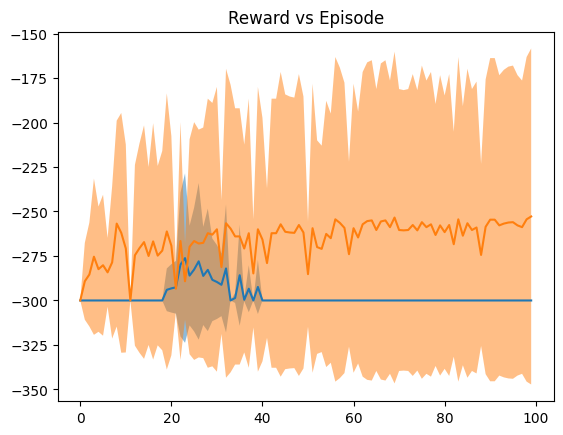

In [11]:
acrobot_mc = HyperEnv('Acrobot-v1', 200, 300, 128, 1e-2, 500, 0.99, 1, 128, 64)
draw_experiment_reinforce(acrobot_mc)